<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Ana Marcela Ramos Gutiérrez.

**Fecha:** 13 de mayo del 2020.

**Expediente** : 714580.
**Profesor:** Oscar David Jaramillo Zuluaga.

# Tarea 11: Clase 23

## Enunciado

> Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:
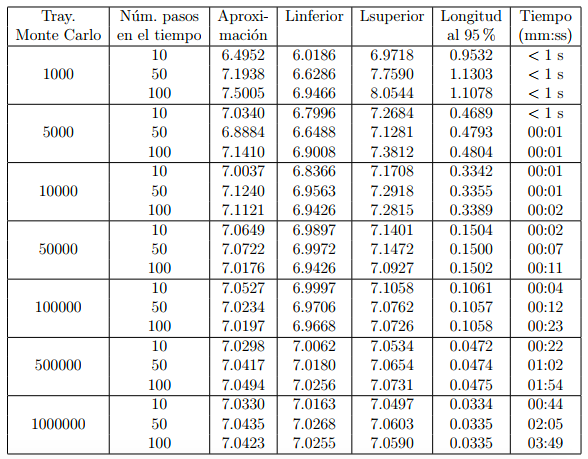

> Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

/Users/marce/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [17]:
def Riemann_approach(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:'call o put',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    if tipo=='call':
        # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
        call = pd.DataFrame({'Prima':np.exp(-r*T) \
                     *np.fmax(Average_t-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
        # intervalos de confianza
        confianza = 0.95
        sigma_est = call.sem().Prima
        mean_est = call.iloc[-1].Prima
        i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
        return call.iloc[-1].Prima, i1
    elif tipo=='put':
        put = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-Average_t,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
        # intervalos de confianza
        confianza = 0.95
        sigma_est = put.sem().Prima
        mean_est = put.iloc[-1].Prima
        i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
        return put.iloc[-1].Prima, i1

**Sumas de Riemann**

$$\int_0^T S_u du \approx h \sum_{i=0}^{n-1} S_{t_i}$$

De este modo, si con el método de Monte Carlo se generan $M$ trayectorias, entonces
la aproximación de el valor del call asiático estaría dada por:

$$\hat V_0^{(1)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({1\over N} \sum_{i=0}^{N-1} S_{t_i}-K \Bigg)_+$$



**Mejorando la aproximación de las sumas de Riemann (esquema del trapecio)**

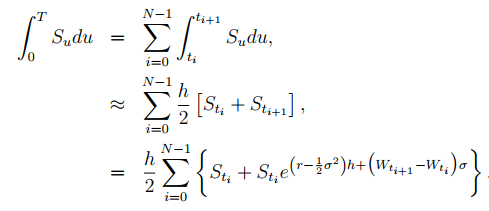

Desarrollando la exponencial en serie de taylor y suponiendo que $h$ es pequeña, sólo se conservan los términos de orden uno, se tiene la siguiente aproximación:
$$\int_0^T S_u du \approx {h \over 2}\sum_{i=0}^{N-1}S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)$$

Reemplazando esta aproximación en el precio del call, se tiene la siguiente estimación:
$$\hat V_0^{(2)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({h\over 2T} \sum_{i=0}^{N-1} S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)-K \Bigg)_+$$
**recordar que $h = \frac{T}{N}$**
> **Referencia**:
http://mat.izt.uam.mx/mat/documentos/notas%20de%20clase/cfenaoe3.pdf

In [13]:
def Riemann_approach2(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:'call o put',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Creamos el segundo DataFrame
    mult= pd.DataFrame(2+r*(T/NbStep)+np.random.randn(NbTraj,NbStep)*sigma).T
    # Multiplicamos los dataframes
    prices_mult= prices*mult
    # Hacemos la sumatoria
    sumprices_mult = np.cumsum(prices_mult)
    # Multiplicamos por h/2 
    sumatoria = sumprices_mult*(1/NbStep)*(1/2)*(1/T)
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    if tipo=='call':
        # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
        call = pd.DataFrame({'Prima':np.exp(-r*T) \
                             *np.fmax(sumatoria-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
        # intervalos de confianza
        confianza = 0.95
        sigma_est = call.sem().Prima
        mean_est = call.iloc[-1].Prima
        i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
        return call.iloc[-1].Prima, i1
    else:
        put = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-sumatoria,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
        # intervalos de confianza
        confianza = 0.95
        sigma_est = put.sem().Prima
        mean_est = put.iloc[-1].Prima
        i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
        return put.iloc[-1].Prima, i1

#### Riemann approach - Trapecio Call

In [14]:
NbStep = [10,50,100]
S0 = 100
r = 0.10
sigma = 0.2
K = 100
T = 1

In [16]:
%%timeit
NbTraj = [1000]
M1000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M1000

39.4 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%%timeit
NbTraj = [5000]
M5000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M5000

133 ms ± 7.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%%timeit
NbTraj = [10000]
M10000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M10000

311 ms ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit
NbTraj = [50000]
M50000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M50000

1.7 s ± 175 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit
NbTraj = [100000]
M100000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M100000

3.2 s ± 192 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
NbTraj = [500000]
M500000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M500000

19.8 s ± 1.29 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
NbTraj = [1000000]
M1000000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M1000000

54.1 s ± 3.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
NbTraj = np.array([1000,5000,10000,50000,100000,500000,1000000])
M = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M

[[(6.867479869346172, (5.518956599450492, 8.216003139241852)),
  (7.00617630616362, (6.591605023227121, 7.4207475891001184)),
  (7.07559916057988, (6.7986944459838785, 7.352503875175881))],
 [(7.034331825694356, (5.654561069789624, 8.414102581599089)),
  (7.016702589368071, (6.6040934919388, 7.429311686797343)),
  (7.22242866375894, (6.937381455171557, 7.5074758723463235))],
 [(6.917736544314452, (5.5616563141751305, 8.273816774453774)),
  (6.965103437830087, (6.555221833598272, 7.374985042061902)),
  (6.906462370351295, (6.6361546208119195, 7.17677011989067))],
 [(6.8855146648744405, (5.5355963861920765, 8.235432943556805)),
  (7.0587067958900285, (6.64129996940939, 7.476113622370667)),
  (6.987148057846988, (6.712287621259599, 7.262008494434377))],
 [(6.885691535990097, (5.535601044720724, 8.23578202725947)),
  (6.987426503379328, (6.575156874976562, 7.399696131782093)),
  (7.007689183450084, (6.732361363360927, 7.28301700353924))],
 [(6.889162879383768, (5.538206208312786, 8.2401195

In [52]:
Aprox = [M[i][j][0] for i in range(7) for j in range(3)]
Aprox

[6.867479869346172,
 7.00617630616362,
 7.07559916057988,
 7.034331825694356,
 7.016702589368071,
 7.22242866375894,
 6.917736544314452,
 6.965103437830087,
 6.906462370351295,
 6.8855146648744405,
 7.0587067958900285,
 6.987148057846988,
 6.885691535990097,
 6.987426503379328,
 7.007689183450084,
 6.889162879383768,
 7.017683881967411,
 7.008343169674199,
 6.9031494836618705,
 7.009094770670147,
 7.0240410566836395]

In [50]:
Linf = [M[i][j][1][0] for i in range(7) for j in range(3)]
Linf

[5.518956599450492,
 6.591605023227121,
 6.7986944459838785,
 5.654561069789624,
 6.6040934919388,
 6.937381455171557,
 5.5616563141751305,
 6.555221833598272,
 6.6361546208119195,
 5.5355963861920765,
 6.64129996940939,
 6.712287621259599,
 5.535601044720724,
 6.575156874976562,
 6.732361363360927,
 5.538206208312786,
 6.603409861474258,
 6.732813339193513,
 5.54930579620858,
 6.595306417728308,
 6.74787275271433]

In [51]:
Lsup = [M[i][j][1][1] for i in range(7) for j in range(3)]
Lsup

[8.216003139241852,
 7.4207475891001184,
 7.352503875175881,
 8.414102581599089,
 7.429311686797343,
 7.5074758723463235,
 8.273816774453774,
 7.374985042061902,
 7.17677011989067,
 8.235432943556805,
 7.476113622370667,
 7.262008494434377,
 8.23578202725947,
 7.399696131782093,
 7.28301700353924,
 8.24011955045475,
 7.431957902460564,
 7.283873000154885,
 8.25699317111516,
 7.422883123611987,
 7.300209360652949]

In [54]:
Long = np.array(Lsup)-np.array(Linf)
Long

array([2.69704654, 0.82914257, 0.55380943, 2.75954151, 0.82521819,
       0.57009442, 2.71216046, 0.81976321, 0.5406155 , 2.69983656,
       0.83481365, 0.54972087, 2.70018098, 0.82453926, 0.55065564,
       2.70191334, 0.82854804, 0.55105966, 2.70768737, 0.82757671,
       0.55233661])

In [62]:
index = [('1000', 10), ('1000', 50), ('1000', 100),
         ('5000', 10), ('5000', 50), ('5000', 100),
         ('10000', 10), ('10000', 50), ('10000', 100),
         ('50000', 10), ('50000', 50), ('50000', 100),
         ('100000', 10), ('100000', 50), ('100000', 100),
         ('500000', 10), ('500000', 50), ('500000', 100),
         ('1000000', 10), ('1000000', 50), ('1000000', 100)]
index = pd.MultiIndex.from_tuples(index, names=('Tray. Monte Carlo', 'Núm Pasos en el tiempo'))
TrapCall = pd.DataFrame({'Aproximación':Aprox,
                     'Lim inferior':Linf,
                     'Lim superior':Lsup,
                     'Longitud al 95%':Long,
                     'Tiempo':['39.4 ms', '39.4 ms', '39.4 ms',
                                       '133.0 ms', '133.0 ms', '133.0 ms',
                                       '311.0 ms', '311.0 ms', '311.0 ms',
                                       '1.7 s', '1.7 s', '1.7 s',
                                       '3.2 s', '3.2 s', '3.2 s',
                                       '19.8 s', '19.8 s', '19.8 s',
                                       '54.1 s', '54.1 s', '54.1 s']}, index= index)
pd.set_option("display.max_rows",None)
TrapCall

Aproximación  Lim inferior  \
Tray. Monte Carlo Núm Pasos en el tiempo                               
1000              10                             6.867         5.519   
                  50                             7.006         6.592   
                  100                            7.076         6.799   
5000              10                             7.034         5.655   
                  50                             7.017         6.604   
                  100                            7.222         6.937   
10000             10                             6.918         5.562   
                  50                             6.965         6.555   
                  100                            6.906         6.636   
50000             10                             6.886         5.536   
                  50                             7.059         6.641   
                  100                            6.987         6.712   
100000            10                             6.886         5.536   
                  50                             6.987         6.575   
                  100                            7.008         6.732   
500000            10                             6.889         5.538   
                  50                             7.018         6.603   
                  100                            7.008         6.733   
1000000           10                             6.903         5.549   
                  50                             7.009         6.595   
                  100                            7.024         6.748   

                                          Lim superior  Longitud al 95%  \
Tray. Monte Carlo Núm Pasos en el tiempo                                  
1000              10                             8.216            2.697   
                  50                             7.421            0.829   
                  100                            7.353            0.554   
5000              10                             8.414            2.760   
                  50                             7.429            0.825   
                  100                            7.507            0.570   
10000             10                             8.274            2.712   
                  50                             7.375            0.820   
                  100                            7.177            0.541   
50000             10                             8.235            2.700   
                  50                             7.476            0.835   
                  100                            7.262            0.550   
100000            10                             8.236            2.700   
                  50                             7.400            0.825   
                  100                            7.283            0.551   
500000            10                             8.240            2.702   
                  50                             7.432            0.829   
                  100                            7.284            0.551   
1000000           10                             8.257            2.708   
                  50                             7.423            0.828   
                  100                            7.300            0.552   

                                            Tiempo  
Tray. Monte Carlo Núm Pasos en el tiempo            
1000              10                       39.4 ms  
                  50                       39.4 ms  
                  100                      39.4 ms  
5000              10                      133.0 ms  
                  50                      133.0 ms  
                  100                     133.0 ms  
10000             10                      311.0 ms  
                  50                      311.0 ms  
                  100                     311.0 ms  
50000             10                         1.7 s  
                  50   

#### Rieman approach - Trapecio Put

In [6]:
NbStep = [10,50,100]
S0 = 100
r = 0.10
sigma = 0.2
K = 100
T = 1

In [72]:
%%timeit
NbTraj = [1000]
M1000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M1000

49.1 ms ± 9.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%%timeit
NbTraj = [5000]
M5000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M5000

141 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
%%timeit
NbTraj = [10000]
M10000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M10000

302 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
%%timeit
NbTraj = [50000]
M50000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M50000

1.67 s ± 92.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
%%timeit
NbTraj = [100000]
M100000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M100000

3.61 s ± 668 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
%%timeit
NbTraj = [500000]
M500000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M500000

20.7 s ± 938 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
NbTraj = [1000000]
M1000000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M1000000

In [7]:
NbTraj = np.array([1000,5000,10000,50000,100000,500000,1000000])
M2 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M2

[[(2.202117089500652, (-14.944457082575815, 19.34869126157712)),
  (2.221551022848315, (-5.248103648994204, 9.691205694690833)),
  (2.5044993161116467, (-2.742707872488205, 7.751706504711498))],
 [(2.0876515169620657, (-15.072813013578102, 19.248116047502233)),
  (2.4172411918456107, (-5.039033563955231, 9.873515947646451)),
  (2.308025141026767, (-2.9523168735937144, 7.568367155647248))],
 [(2.1848832276996717, (-14.93948021432736, 19.309246669726704)),
  (2.3828922224442524, (-5.07227558938505, 9.838060034273555)),
  (2.363720690094428, (-2.8920937135568576, 7.619535093745714))],
 [(2.1882276754837564, (-14.939583471142427, 19.316038822109938)),
  (2.345656327020272, (-5.113006182940315, 9.804318836980858)),
  (2.357438723600741, (-2.9012892384661586, 7.61616668566764))],
 [(2.2462392888172906, (-14.86204680174521, 19.35452537937979)),
  (2.3451702014163303, (-5.115755471416296, 9.806095874248957)),
  (2.3389475818687786, (-2.9178738334552254, 7.595768997192783))],
 [(2.2248860633457

In [10]:
Aprox2 = [M2[i][j][0] for i in range(7) for j in range(3)]
Linf2 = [M2[i][j][1][0] for i in range(7) for j in range(3)]
Lsup2 = [M2[i][j][1][1] for i in range(7) for j in range(3)]
Long2 = np.array(Lsup2)-np.array(Linf2)

In [11]:
index = [('1000', 10), ('1000', 50), ('1000', 100),
         ('5000', 10), ('5000', 50), ('5000', 100),
         ('10000', 10), ('10000', 50), ('10000', 100),
         ('50000', 10), ('50000', 50), ('50000', 100),
         ('100000', 10), ('100000', 50), ('100000', 100),
         ('500000', 10), ('500000', 50), ('500000', 100),
         ('1000000', 10), ('1000000', 50), ('1000000', 100)]
index = pd.MultiIndex.from_tuples(index, names=('Tray. Monte Carlo', 'Núm Pasos en el tiempo'))
TrapPut = pd.DataFrame({'Aproximación':Aprox2,
                     'Lim inferior':Linf2,
                     'Lim superior':Lsup2,
                     'Longitud al 95%':Long2,
                     'Tiempo':['49.1 ms', '49.1 ms', '49.1 ms',
                                       '141.0 ms', '141.0 ms', '141.0 ms',
                                       '302.0 ms', '302.0 ms', '302.0 ms',
                                       '1.6 s', '1.6 s', '1.6 s',
                                       '3.6 s', '3.6 s', '3.6 s',
                                       '20.7 s', '20.7 s', '20.7 s',
                                       '54.1 s', '54.1 s', '54.1 s']}, index= index)
pd.set_option("display.max_rows",None)
TrapPut

Aproximación  Lim inferior  \
Tray. Monte Carlo Núm Pasos en el tiempo                               
1000              10                             2.202       -14.944   
                  50                             2.222        -5.248   
                  100                            2.504        -2.743   
5000              10                             2.088       -15.073   
                  50                             2.417        -5.039   
                  100                            2.308        -2.952   
10000             10                             2.185       -14.939   
                  50                             2.383        -5.072   
                  100                            2.364        -2.892   
50000             10                             2.188       -14.940   
                  50                             2.346        -5.113   
                  100                            2.357        -2.901   
100000            10                             2.246       -14.862   
                  50                             2.345        -5.116   
                  100                            2.339        -2.918   
500000            10                             2.225       -14.890   
                  50                             2.328        -5.134   
                  100                            2.341        -2.917   
1000000           10                             2.223       -14.895   
                  50                             2.327        -5.135   
                  100                            2.347        -2.910   

                                          Lim superior  Longitud al 95%  \
Tray. Monte Carlo Núm Pasos en el tiempo                                  
1000              10                            19.349           34.293   
                  50                             9.691           14.939   
                  100                            7.752           10.494   
5000              10                            19.248           34.321   
                  50                             9.874           14.913   
                  100                            7.568           10.521   
10000             10                            19.309           34.249   
                  50                             9.838           14.910   
                  100                            7.620           10.512   
50000             10                            19.316           34.256   
                  50                             9.804           14.917   
                  100                            7.616           10.517   
100000            10                            19.355           34.217   
                  50                             9.806           14.922   
                  100                            7.596           10.514   
500000            10                            19.340           34.230   
                  50                             9.791           14.925   
                  100                            7.600           10.517   
1000000           10                            19.341           34.236   
                  50                             9.790           14.925   
                  100                            7.604           10.514   

                                            Tiempo  
Tray. Monte Carlo Núm Pasos en el tiempo            
1000              10                       49.1 ms  
                  50                       49.1 ms  
                  100                      49.1 ms  
5000              10                      141.0 ms  
                  50                      141.0 ms  
                  100                     141.0 ms  
10000             10                      302.0 ms  
                  50                      302.0 ms  
                  100                     302.0 ms  
50000             10                         1.6 s  
                  50   

#### Riemann Approach - Rectangular

In [15]:
NbStep = [10,50,100]
S0 = 100
r = 0.10
sigma = 0.2
K = 100
T = 1

In [ ]:
%%timeit
NbTraj = [1000]
M1000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M1000

In [ ]:
%%timeit
NbTraj = [5000]
M5000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M5000

In [ ]:
%%timeit
NbTraj = [10000]
M10000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M10000

In [ ]:
%%timeit
NbTraj = [50000]
M50000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M50000

In [ ]:
%%timeit
NbTraj = [100000]
M100000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M100000

In [ ]:
%%timeit
NbTraj = [500000]
M500000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M500000

In [ ]:
%%timeit
NbTraj = [1000000]
M1000000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M1000000

In [19]:
NbTraj = np.array([1000,5000,10000,50000,100000,500000,1000000])
M3 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"call"),NbStep)),NbTraj))
M3

[[(6.7549402257042495, (5.421291835859567, 8.088588615548932)),
  (6.854325728367902, (6.34597740200401, 7.362674054731794)),
  (6.492083251925044, (6.162827009902718, 6.821339493947371))],
 [(6.348499858586275, (5.08873142567831, 7.608268291494241)),
  (6.957800693874201, (6.435062750788139, 7.480538636960264)),
  (6.9854119845921865, (6.6297717106561125, 7.3410522585282605))],
 [(6.424997256731172, (5.154934767821313, 7.69505974564103)),
  (6.778746625114435, (6.275323407117835, 7.282169843111035)),
  (7.07600117879449, (6.712825664970801, 7.4391766926181795))],
 [(6.419057857084071, (5.145096933581541, 7.693018780586601)),
  (6.896285836281966, (6.381436495841696, 7.411135176722237)),
  (6.9964782465720425, (6.635755443209297, 7.357201049934788))],
 [(6.395858387518101, (5.129164756404834, 7.662552018631367)),
  (6.890284769491417, (6.3765434640478755, 7.404026074934958)),
  (7.006626780288563, (6.645689708117856, 7.367563852459271))],
 [(6.42985441608374, (5.15454210884953, 7.70516

In [20]:
Aprox3 = [M3[i][j][0] for i in range(7) for j in range(3)]
Linf3 = [M3[i][j][1][0] for i in range(7) for j in range(3)]
Lsup3 = [M3[i][j][1][1] for i in range(7) for j in range(3)]
Long3 = np.array(Lsup3)-np.array(Linf3)

In [21]:
index = [('1000', 10), ('1000', 50), ('1000', 100),
         ('5000', 10), ('5000', 50), ('5000', 100),
         ('10000', 10), ('10000', 50), ('10000', 100),
         ('50000', 10), ('50000', 50), ('50000', 100),
         ('100000', 10), ('100000', 50), ('100000', 100),
         ('500000', 10), ('500000', 50), ('500000', 100),
         ('1000000', 10), ('1000000', 50), ('1000000', 100)]
index = pd.MultiIndex.from_tuples(index, names=('Tray. Monte Carlo', 'Núm Pasos en el tiempo'))
RecCall = pd.DataFrame({'Aproximación':Aprox3,
                     'Lim inferior':Linf3,
                     'Lim superior':Lsup3,
                     'Longitud al 95%':Long3,
                     'Tiempo':['49.1 ms', '49.1 ms', '49.1 ms',
                                       '141.0 ms', '141.0 ms', '141.0 ms',
                                       '302.0 ms', '302.0 ms', '302.0 ms',
                                       '1.6 s', '1.6 s', '1.6 s',
                                       '3.6 s', '3.6 s', '3.6 s',
                                       '20.7 s', '20.7 s', '20.7 s',
                                       '54.1 s', '54.1 s', '54.1 s']}, index= index)
pd.set_option("display.max_rows",None)
RecCall

Aproximación  Lim inferior  \
Tray. Monte Carlo Núm Pasos en el tiempo                               
1000              10                             6.755         5.421   
                  50                             6.854         6.346   
                  100                            6.492         6.163   
5000              10                             6.348         5.089   
                  50                             6.958         6.435   
                  100                            6.985         6.630   
10000             10                             6.425         5.155   
                  50                             6.779         6.275   
                  100                            7.076         6.713   
50000             10                             6.419         5.145   
                  50                             6.896         6.381   
                  100                            6.996         6.636   
100000            10                             6.396         5.129   
                  50                             6.890         6.377   
                  100                            7.007         6.646   
500000            10                             6.430         5.155   
                  50                             6.926         6.409   
                  100                            6.983         6.623   
1000000           10                             6.420         5.147   
                  50                             6.925         6.408   
                  100                            6.968         6.609   

                                          Lim superior  Longitud al 95%  \
Tray. Monte Carlo Núm Pasos en el tiempo                                  
1000              10                             8.089            2.667   
                  50                             7.363            1.017   
                  100                            6.821            0.659   
5000              10                             7.608            2.520   
                  50                             7.481            1.045   
                  100                            7.341            0.711   
10000             10                             7.695            2.540   
                  50                             7.282            1.007   
                  100                            7.439            0.726   
50000             10                             7.693            2.548   
                  50                             7.411            1.030   
                  100                            7.357            0.721   
100000            10                             7.663            2.533   
                  50                             7.404            1.027   
                  100                            7.368            0.722   
500000            10                             7.705            2.551   
                  50                             7.442            1.034   
                  100                            7.343            0.720   
1000000           10                             7.693            2.546   
                  50                             7.442            1.034   
                  100                            7.327            0.718   

                                            Tiempo  
Tray. Monte Carlo Núm Pasos en el tiempo            
1000              10                       49.1 ms  
                  50                       49.1 ms  
                  100                      49.1 ms  
5000              10                      141.0 ms  
                  50                      141.0 ms  
                  100                     141.0 ms  
10000             10                      302.0 ms  
                  50                      302.0 ms  
                  100                     302.0 ms  
50000             10                         1.6 s  
                  50   

#### Riemann Approach - Rectangular

In [ ]:
%%timeit
NbTraj = [1000]
M1000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M1000

In [ ]:
%%timeit
NbTraj = [5000]
M5000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M5000

In [ ]:
%%timeit
NbTraj = [10000]
M10000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M10000

In [ ]:
%%timeit
NbTraj = [50000]
M50000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M50000

In [ ]:
%%timeit
NbTraj = [100000]
M100000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M100000

In [ ]:
%%timeit
NbTraj = [500000]
M50000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M50000

In [ ]:
%%timeit
NbTraj = [1000000]
M1000000 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M1000000

In [22]:
NbTraj = np.array([1000,5000,10000,50000,100000,500000,1000000])
M4 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach(K,r,S0,N_tra,N_ste,sigma,T,"put"),NbStep)),NbTraj))
M4

[[(2.1932715925381983, (1.780277181054837, 2.6062660040215597)),
  (2.4276373126142703, (2.270659049522155, 2.5846155757063856)),
  (2.2610048837149486, (2.1648916003978442, 2.357118167032053))],
 [(2.220067379476859, (1.7950202822895782, 2.6451144766641397)),
  (2.3690039680216755, (2.221071592993343, 2.516936343050008)),
  (2.3809897037454713, (2.2801196949727656, 2.481859712518177))],
 [(2.2581622944713353, (1.828638991358005, 2.6876855975846654)),
  (2.2811719609484076, (2.138044921109959, 2.4242990007868563)),
  (2.2633255098691922, (2.1681082727456973, 2.358542746992687))],
 [(2.2533758353063194, (1.8211351484015164, 2.6856165222111223)),
  (2.3176052608741813, (2.1716525576284385, 2.463557964119924)),
  (2.370453003214581, (2.2692162724453833, 2.4716897339837787))],
 [(2.196446622922379, (1.7746487533426225, 2.6182444925021353)),
  (2.3212233574466308, (2.1739739602417156, 2.468472754651546)),
  (2.365530055973584, (2.2641210042843394, 2.466939107662829))],
 [(2.227849590852519,

In [23]:
Aprox4 = [M4[i][j][0] for i in range(7) for j in range(3)]
Linf4 = [M4[i][j][1][0] for i in range(7) for j in range(3)]
Lsup4 = [M4[i][j][1][1] for i in range(7) for j in range(3)]
Long4 = np.array(Lsup4)-np.array(Linf4)

In [24]:
index = [('1000', 10), ('1000', 50), ('1000', 100),
         ('5000', 10), ('5000', 50), ('5000', 100),
         ('10000', 10), ('10000', 50), ('10000', 100),
         ('50000', 10), ('50000', 50), ('50000', 100),
         ('100000', 10), ('100000', 50), ('100000', 100),
         ('500000', 10), ('500000', 50), ('500000', 100),
         ('1000000', 10), ('1000000', 50), ('1000000', 100)]
index = pd.MultiIndex.from_tuples(index, names=('Tray. Monte Carlo', 'Núm Pasos en el tiempo'))
RecPut = pd.DataFrame({'Aproximación':Aprox4,
                     'Lim inferior':Linf4,
                     'Lim superior':Lsup4,
                     'Longitud al 95%':Long4,
                     'Tiempo':['49.1 ms', '49.1 ms', '49.1 ms',
                                       '141.0 ms', '141.0 ms', '141.0 ms',
                                       '302.0 ms', '302.0 ms', '302.0 ms',
                                       '1.6 s', '1.6 s', '1.6 s',
                                       '3.6 s', '3.6 s', '3.6 s',
                                       '20.7 s', '20.7 s', '20.7 s',
                                       '54.1 s', '54.1 s', '54.1 s']}, index= index)
pd.set_option("display.max_rows",None)
RecPut

Aproximación  Lim inferior  \
Tray. Monte Carlo Núm Pasos en el tiempo                               
1000              10                             2.193         1.780   
                  50                             2.428         2.271   
                  100                            2.261         2.165   
5000              10                             2.220         1.795   
                  50                             2.369         2.221   
                  100                            2.381         2.280   
10000             10                             2.258         1.829   
                  50                             2.281         2.138   
                  100                            2.263         2.168   
50000             10                             2.253         1.821   
                  50                             2.318         2.172   
                  100                            2.370         2.269   
100000            10                             2.196         1.775   
                  50                             2.321         2.174   
                  100                            2.366         2.264   
500000            10                             2.228         1.801   
                  50                             2.343         2.194   
                  100                            2.352         2.252   
1000000           10                             2.228         1.801   
                  50                             2.338         2.190   
                  100                            2.347         2.248   

                                          Lim superior  Longitud al 95%  \
Tray. Monte Carlo Núm Pasos en el tiempo                                  
1000              10                             2.606            0.826   
                  50                             2.585            0.314   
                  100                            2.357            0.192   
5000              10                             2.645            0.850   
                  50                             2.517            0.296   
                  100                            2.482            0.202   
10000             10                             2.688            0.859   
                  50                             2.424            0.286   
                  100                            2.359            0.190   
50000             10                             2.686            0.864   
                  50                             2.464            0.292   
                  100                            2.472            0.202   
100000            10                             2.618            0.844   
                  50                             2.468            0.294   
                  100                            2.467            0.203   
500000            10                             2.655            0.854   
                  50                             2.492            0.298   
                  100                            2.452            0.200   
1000000           10                             2.656            0.855   
                  50                             2.486            0.297   
                  100                            2.447            0.200   

                                            Tiempo  
Tray. Monte Carlo Núm Pasos en el tiempo            
1000              10                       49.1 ms  
                  50                       49.1 ms  
                  100                      49.1 ms  
5000              10                      141.0 ms  
                  50                      141.0 ms  
                  100                     141.0 ms  
10000             10                      302.0 ms  
                  50                      302.0 ms  
                  100                     302.0 ms  
50000             10                         1.6 s  
                  50   

### Conclusiones
En conclusión se puede decir que a partir de los dos métodos de aproximación mediante sumas de Riemann, se comprueba una vez más que el método del trapecio es más efectivo que el método de rectángulos. Además, se pudo crear una función que unió los aprendizajes de clase y que evalúa las opciones independientemente de si son Call o Put y regresa tanto el valor de la prima como los límites superiores e inferiores a partir de las 100000 estimaciones, los valores no fueron tan cambiantes, sin embargo el tiempo de ejecución aumentó exponencialmente, por lo que tal vez se concluye que para este opciones, el número de trayectorias no tiene que ser tan grande. Por otra parte, se aprendió a medir el tiempo que tardan las celdas en correr, así como a crear índices múltiples en DataFrames.